## Four-Step Model in Python by David Bailey (First Part)

 source: https://davidabailey.com/articles/Creating-a-Four-step-Transportation-Model-in-Python 
 This codes reads Travels produced by cars from the Census Web page and reads Employment from the 
 Bureau of Labor statistics, generates Trip Production Trip Attraction per County and a Trip
 Distribution Model, we show today the first part.

In [27]:
!pip install haversine

In [28]:
!pip install ipfn

In [29]:
import requests
import pandas
import geopandas
import json
import math
from haversine import haversine
import ipfn
import networkx
from matplotlib import pyplot
from matplotlib import patheffects
%matplotlib inline  

In [30]:
#conda install -c conda-forge libspatialindex

In [31]:
import sys
print("The Python version is %s.%s.%s" % sys.version_info[:3])

The Python version is 3.7.7


## Check:
https://conda.io/docs/user-guide/tasks/manage-environments.html#activate-env

http://geopandas.org/install.html

In [32]:
url = 'https://tigerweb.geo.census.gov/arcgis/rest/services/TIGERweb/State_County/MapServer/37/query?where=state%3D06&f=geojson'
r = requests.get(url)
zones = geopandas.GeoDataFrame.from_features(r.json()['features'])

In [33]:
centroidFunction = lambda row: (row['geometry'].centroid.y, row['geometry'].centroid.x)
zones['centroid'] = zones.apply(centroidFunction, axis=1)

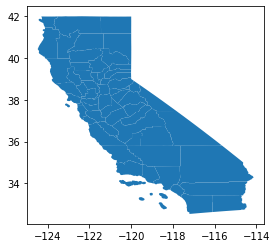

In [34]:
zones.plot()
pyplot.show()

In [35]:
gdf = geopandas.GeoDataFrame

In [36]:
zones.dtypes

geometry    geometry
NAME          object
centroid      object
dtype: object

Query example from the US Census API:
https://www.census.gov/data/developers/guidance/api-user-guide/query-examples.html

In [37]:
url ='https://api.census.gov/data/2015/acs/acs5?get=NAME,B08015_001E&for=county&in=state:06&key=''
r = requests.get(url) 

In [38]:
r.json()

[['NAME', 'B08015_001E', 'state', 'county'],
 ['Alameda County, California', '488780', '06', '001'],
 ['Alpine County, California', '270', '06', '003'],
 ['Amador County, California', '9975', '06', '005'],
 ['Butte County, California', '69100', '06', '007'],
 ['Calaveras County, California', '13125', '06', '009'],
 ['Colusa County, California', '7125', '06', '011'],
 ['Contra Costa County, California', '367415', '06', '013'],
 ['Del Norte County, California', '6585', '06', '015'],
 ['El Dorado County, California', '62135', '06', '017'],
 ['Fresno County, California', '296510', '06', '019'],
 ['Glenn County, California', '8230', '06', '021'],
 ['Humboldt County, California', '43290', '06', '023'],
 ['Imperial County, California', '48310', '06', '025'],
 ['Inyo County, California', '5935', '06', '027'],
 ['Kern County, California', '267185', '06', '029'],
 ['Kings County, California', '44005', '06', '031'],
 ['Lake County, California', '17170', '06', '033'],
 ['Lassen County, California'

In [41]:
#Production = pandas.DataFrame(r.json()[1:], columns = r.json()[0])
Production = pandas.DataFrame(r.json()[1:], columns = r.json()[0], dtype='int')
nameSplit = lambda x: x.split(',')[0]
Production['NAME'] = Production['NAME'].apply(nameSplit)
zones = pandas.merge(zones, Production)
zones['Production'] = zones['B08015_001E']

In [65]:
zones.head()

,geometry,NAME,centroid,B08015_001E,state,county,Production,Attraction
0,"POLYGON ((-120.07333 38.70109, -120.07332 38.7...",Alpine County,"(38.59725063317207, -119.82065303034453)",270,06,003,270,None
1,"POLYGON ((-121.11866 38.71707, -121.11176 38.7...",El Dorado County,"(38.778737042440646, -120.52465107178368)",62135,06,017,62135,None
2,"POLYGON ((-121.59768 39.12779, -121.59773 39.1...",Yuba County,"(39.26900765367862, -121.3512627386866)",21565,06,115,21565,None
3,"POLYGON ((-122.16494 38.64246, -122.16502 38.6...",Yolo County,"(38.68666040139593, -121.90161702501356)",65060,06,113,65060,None
4,"POLYGON ((-121.48300 36.76505, -121.48295 36.7...",San Benito County,"(36.60570589668711, -121.07499552455516)",21420,06,069,21420,None


In [66]:
zones

,geometry,NAME,centroid,B08015_001E,state,county,Production,Attraction
0,"POLYGON ((-120.07333 38.70109, -120.07332 38.7...",Alpine County,"(38.59725063317207, -119.82065303034453)",270,06,003,270,None
1,"POLYGON ((-121.11866 38.71707, -121.11176 38.7...",El Dorado County,"(38.778737042440646, -120.52465107178368)",62135,06,017,62135,None
2,"POLYGON ((-121.59768 39.12779, -121.59773 39.1...",Yuba County,"(39.26900765367862, -121.3512627386866)",21565,06,115,21565,None
3,"POLYGON ((-122.16494 38.64246, -122.16502 38.6...",Yolo County,"(38.68666040139593, -121.90161702501356)",65060,06,113,65060,None
4,"POLYGON ((-121.48300 36.76505, -121.48295 36.7...",San Benito County,"(36.60570589668711, -121.07499552455516)",21420,06,069,21420,None
5,"POLYGON ((-120.42219 36.84014, -120.42238 36.8...",Fresno County,"(36.75818012643308, -119.64932262926772)",296510,06,019,296510,None
6,"POLYGON ((-124.31611 41.72839, -124.31370 41.7...",Del Norte County,"(41.74494236554737, -123.95780135595136)",6585,06,015,6585,None
7,"POLYGON ((-124.28140 40.79915, -124.28658 40.7...",Humboldt County,"(40.70500907826406, -123.91581944402172)",43290,06,023,43290,None
8,"POLYGON ((-119.91366 35.43926, -119.91230 35.4...",Kern County,"(35.34285593411939, -118.72990396493257)",267185,06,029,267185,None
9,"POLYGON ((-121.20789 38.24882, -121.20805 38.2...",San Joaquin County,"(37.93474703225379, -121.2714032752314)",225340,06,077,225340,None


In [68]:
zones.dtypes

geometry       geometry
NAME             object
centroid         object
B08015_001E      object
state            object
county           object
Production       object
Attraction       object
dtype: object

In [69]:
zones.astype({'Production': 'int64','state': 'int64','county':'int64'}).dtypes

geometry       geometry
NAME             object
centroid         object
B08015_001E      object
state             int64
county            int64
Production        int64
Attraction       object
dtype: object

In [80]:
def getEmployment(state, county):
    prefix = 'EN'
    seasonal_adjustment = 'U'
    area = format(state, "02d") + format(county, "03d")
    data_type = '1'
    size = '0'
    ownership = '0'
    industry = '10'
    seriesid = prefix + seasonal_adjustment + area + data_type + size + ownership + industry
    headers = {'Content-type': 'application/json'}
    data = json.dumps({"seriesid": [seriesid],"startyear":"2015", "endyear":"2015","registrationKey":"5032bc384942419cb895bb2583d5f944"})
    p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
    employment = p.json()['Results']['series'][0]['data'][0]['value']
    print(area,' ',employment)
    return(employment)

Read me Bureau of labor statistics: https://www.bls.gov/help/hlpforma.html
        
LBS API example: https://www.bls.gov/developers/api_python.htm#python1
        
Get your API: https://data.bls.gov/registrationEngine/

In [81]:
#employment = lambda row: int(getEmployment('06','003')) 
employment = lambda row: int(getEmployment(int(row['state']),int(row['county'])))

In [82]:
!pip install apply

In [83]:
zones['Attraction'] = None

### This part retrieves employment from Census can take 1min for each county

In [ ]:
zones['Attraction'] = zones.transpose().apply(employment)

06003   531
06017   53161
06115   16419
06113   96663
06069   15416
06019   363634
06015   7898
06023   47564
06029   307076
06077   233435
06065   680905
06103   17025
06039   46472
06085   1041314
06049   2310
06007   79361
06107   152947
06001   741843
06011   8358
06059   1551455
06025   64118
06101   28401
06057   30768
06047   74061
06099   179694
06105   2636
06013   355341
06055   73022
06027   7551
06111   321003
06031   45680
06073   1400645
06051   7416
06109   17005
06095   134160
06071   724618
06075   696122
06089   64597
06053   166022
06061   151854
06045   31671
06041   114168
06043   4934
06035   9949
06033   15457
06009   8888
06005   11500
06063   5642
06081   393661
06091   495
06087   97624
06079   113646
06021   8651
06037   4355391
06093   12735
06067   638371
06083   192153


In [58]:
getEmployment(6,3)

'531'

In [ ]:
zones.head()

In [ ]:
pandas.set_option('display.float_format', lambda x: '%.0f' % x)
zones[['Production', 'Attraction']].head()

In [ ]:
zones.index = zones.NAME #adds column Name to index column and sorts
zones.sort_index(inplace=True)

In [ ]:
pandas.set_option('display.float_format', lambda x: '%.0f' % x)
zones[['Production', 'Attraction']].head()

### Here we scale Trip production to match total employment

In [ ]:
zones['Production'] = zones['Production'] * zones.sum()['Attraction'] / zones.sum()['Production'] 

In [ ]:
pandas.set_option('display.float_format', lambda x: '%.0f' % x)
zones[['Production', 'Attraction']].head()

# This part uses the ipfn function to generate trip distribtion it starts with an example of themethod.

In [235]:
#Runs the ipfn method from a dataframe df, aggregates/marginals and the dimension(s) preserved.
#For example:
from ipfn import ipfn
import pandas as pd
age = [30, 30, 30, 30, 40, 40, 40, 40, 50, 50, 50, 50]
distance = [10,20,30,40,10,20,30,40,10,20,30,40]
m = [8., 4., 6., 7., 3., 6., 5., 2., 9., 11., 3., 1.]
df = pd.DataFrame()
df['age'] = age
df['distance'] = distance
df['total'] = m
print(df)
xip = df.groupby('age')['total'].sum()

    age  distance  total
0    30        10      8
1    30        20      4
2    30        30      6
3    30        40      7
4    40        10      3
5    40        20      6
6    40        30      5
7    40        40      2
8    50        10      9
9    50        20     11
10   50        30      3
11   50        40      1


In [236]:
xip  #by age initially sums 65

age
30   25
40   16
50   24
Name: total, dtype: float64

In [237]:
#xip changes to 60
xip.loc[30] = 20
xip.loc[40] = 18
xip.loc[50] = 22

In [238]:
xpj = df.groupby('distance')['total'].sum()

In [239]:
xpj #stays in 65

distance
10   20
20   21
30   14
40   10
Name: total, dtype: float64

In [240]:
dimensions = [['age'], ['distance']]
aggregates = [xip, xpj]
IPF = ipfn.ipfn(df, aggregates, dimensions)
df = IPF.iteration()

ipfn converged: convergence_rate not updating or below rate_tolerance


In [241]:
print(df)

    distance  age  total
0         10   30      7
1         20   30      3
2         30   30      5
3         40   30      6
4         10   40      4
5         20   40      7
6         30   40      6
7         40   40      3
8         10   50      9
9         20   50     11
10        30   50      3
11        40   50      1


In [242]:
print(df.groupby('age')['total'].sum(), xip) #after ipf goes to xip

age
30   22
40   20
50   24
Name: total, dtype: float64 age
30   20
40   18
50   22
Name: total, dtype: float64


In [243]:
print(df.groupby('distance')['total'].sum(), xpj) #without changing totals by distance

distance
10   20
20   21
30   14
40   10
Name: total, dtype: float64 distance
10   20
20   21
30   14
40   10
Name: total, dtype: float64


#### Now we generate a cost function based on distances between origins and destinations

In [ ]:
def costFunction(zones, zone1, zone2, beta):
    cost = math.exp(-beta * haversine(zones[zone1]['centroid'], zones[zone2]['centroid']))
    return(cost)

In [ ]:
def costMatrixGenerator(zones, costFunction, beta):
    originList = []
    for originZone in zones:
        destinationList = []
        for destinationZone in zones:
            destinationList.append(costFunction(zones, originZone, destinationZone, beta))
        originList.append(destinationList)
    return(pandas.DataFrame(originList, index=zones.columns, columns=zones.columns))

In [ ]:
costMatrix=[]
beta = 0.01

In [ ]:
costMatrix = costMatrixGenerator(zones.transpose(),costFunction,beta)

In [ ]:
costMatrix

#### GENERATES Trip Distribution keeping marginals of production and attractiom

In [ ]:
def tripDistribution(tripGeneration,costMatrix):
    costMatrix['ozone'] = costMatrix.columns
    costMatrix = costMatrix.melt(id_vars=['ozone'])
    costMatrix.columns = ['ozone', 'dzone', 'total']
    production = tripGeneration['Production']
    production.index.name = 'ozone'
    attraction = tripGeneration['Attraction']
    attraction.index.name = 'dzone'
    aggregates = [production, attraction]
    dimensions = [['ozone'], ['dzone']]
    IPF = ipfn.ipfn(costMatrix, aggregates, dimensions)
    trips = IPF.iteration()
    return(trips.pivot(index='ozone', columns='dzone', values='total'))

In [ ]:
trips = tripDistribution(zones, costMatrix)

In [ ]:
def modeChoiceFunction(zones, zone1, zone2, modes):
    distance = haversine(zones[zone1]['centroid'], zones[zone2]['centroid'])
    probability = {}
    total = 0.0
    for mode in modes:
        total = total + math.exp(modes[mode] * distance)
    for mode in modes:
        probability[mode] = math.exp(modes[mode] * distance) / total
    return(probability)

In [ ]:
def probabilityMatrixGenerator (zones, modeChoiceFunction, modes):
    probabilityMatrix = {}
    for mode in modes:
        originList = []
        for originZone in zones:
            destinationList = []
            for destinationZone in zones:
                destinationList.append(modeChoiceFunction(zones, originZone, destinationZone, modes)[mode])
            originList.append(destinationList)
        probabilityMatrix[mode] = pandas.DataFrame(originList, index=zones.columns, columns=zones.columns)
    return(probabilityMatrix)

In [ ]:
modes = {'walking': .05, 'cycling': .05, 'driving': .05}
probabilityMatrix = probabilityMatrixGenerator(zones.transpose(), modeChoiceFunction, modes)

In [ ]:
drivingTrips = Trips * probabilityMatrix['driving']

In [ ]:
def routeAssignment(zones, trips):
    G = networkx.Graph()
    G.add_nodes_from(zones.columns)
    for zone1 in zones:
        for zone2 in zones:
            if zones[zone1]['geometry'].touches(zones[zone2]['geometry']):
                G.add_edge(zone1, zone2, distance = haversine(zones[zone1]['centroid'], zones[zone2]['centroid']), volume=0.0)
    for origin in trips:
        for destination in trips:
            path = networkx.shortest_path(G, origin, destination)
        for i in range(len(path) - 1):
            G[path[i]][path[i + 1]]['volume'] = G[path[i]][path[i + 1]]['volume'] + trips[zone1][zone2]
    return(G)

In [ ]:
def visualize(G, zones):
    fig = pyplot.figure(1, figsize=(10, 10), dpi=90)
    ax = fig.add_subplot(111)
    zonesT = zones.transpose()
    for i, row in zones.transpose().iterrows():
        text = pyplot.annotate(s=row['NAME'], xy=((row['centroid'][1], row['centroid'][0])), horizontalalignment='center', fontsize=6)
        text.set_path_effects([patheffects.Stroke(linewidth=3, foreground='white'), patheffects.Normal()])
        
    for zone1,zone2,w in G.edges(data=True):
        volume=list(dict(w).values())
        #print zone1,' ',zone2,' ',volume[0]
        x = [zones[zone1]['centroid'][1], zones[zone2]['centroid'][1]]
        y = [zones[zone1]['centroid'][0], zones[zone2]['centroid'][0]]
        ax.plot(x, y, color='#444444', linewidth=volume[0]/500, solid_capstyle='round', zorder=1)
    zonesT.plot(ax = ax,color='#DAF7A6')
    pyplot.show(block=False)    

In [ ]:
G = routeAssignment(zones.transpose(), drivingTrips)

In [ ]:
G

In [ ]:
visualize(G, zones.transpose())

## For playing with parameters

In [ ]:
# Trip Distribution
beta = 0.001
costMatrix = costMatrixGenerator(zones.transpose(), costFunction, beta)
Trips = tripDistribution(zones, costMatrix)
# Mode Choice
modes = {'walking': .05, 'cycling': .05, 'driving': .05}
probabilityMatrix = probabilityMatrixGenerator(zones.transpose(), modeChoiceFunction, modes)
drivingTrips = Trips * probabilityMatrix['driving']
# Route Assignment
G = routeAssignment(zones.transpose(), drivingTrips)
visualize(G, zones.transpose())

In [ ]:
G.number_of_edges()

In [ ]:
58*58

In [ ]:
len(zones)